## Detalhamento das alterações

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
from skimage.measure import label,regionprops
from numba import jit
from sklearn.cluster import KMeans

## Primeira - modelo.py - class Model:

Antes:


In [5]:
path = "MODEL"
templates_names = os.listdir(os.path.join(path,'classes')) 
classes = [cv2.imread(os.path.join(path,'classes',name),cv2.IMREAD_GRAYSCALE) for name in templates_names]

for i,classe in enumerate(classes):
    print(f'i = {i},classe = {templates_names[i]}')

i = 0,classe = 8.png
i = 1,classe = 5.png
i = 2,classe = 3.png
i = 3,classe = 9.png
i = 4,classe = 4.png
i = 5,classe = 0.png
i = 6,classe = 2.png
i = 7,classe = 1.png
i = 8,classe = 7.png
i = 9,classe = 6.png


A classe que o modelo estava pegando (i) não correspondia necessariamente a classe correta da imagem do modelo, só adicionei um sorted pra corrigir.

In [7]:
path = "MODEL"
templates_names = os.listdir(os.path.join(path,'classes')) 
classes = [cv2.imread(os.path.join(path,'classes',name),cv2.IMREAD_GRAYSCALE) for name in sorted(templates_names)]

for i,classe in enumerate(classes):
    print(f'i = {i},classe = {sorted(templates_names)[i]}')


i = 0,classe = 0.png
i = 1,classe = 1.png
i = 2,classe = 2.png
i = 3,classe = 3.png
i = 4,classe = 4.png
i = 5,classe = 5.png
i = 6,classe = 6.png
i = 7,classe = 7.png
i = 8,classe = 8.png
i = 9,classe = 9.png


## Distribuição das classes:

#### Código da criação do modelo:

In [11]:
colors = {'artery':np.array([255,0,0]),
          'liver':np.array([255,0,255]),
          'stomach':np.array([0,255,0]),
          'vein':np.array([0,0,255])}
folder = 'ARRAY_FORMAT'
data_files = [os.path.join(folder,name) for name in os.listdir(folder)]
ORGAOS = ['artery', 'liver', 'stomach', 'vein']
len(data_files)
def load(name):
    data = np.load(name,allow_pickle=True).flatten()[0]
    img = data['image']
    structures = data['structures']
    if len(img.shape) == 3:
        img = img[:,:,0]
    return img,structures

def detect_main_area(img):
    mask = (img > 0).astype('uint8')
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(25,25))
    mask = cv2.erode(mask,kernel,iterations = 1)
    mask = cv2.dilate(mask,kernel,iterations = 1)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(95,95))
    mask = cv2.dilate(mask,kernel,iterations = 1)
    mask = cv2.erode(mask,kernel,iterations = 1)
    objetos = label(mask)
    info = regionprops(objetos)
    main_label = max(info,key = lambda x: x['area'])['label']
    return objetos == main_label

def clean(img):
    return (img * (detect_main_area(img))).astype('uint8')

def create_reshape(img_clean):
    img = img_clean
    arx = np.arange(img.shape[1])
    ary = np.arange(img.shape[0])
    min_y = min(ary,key = lambda x: np.inf if (img[x] == 0).all() else x)
    max_y = max(ary,key = lambda x: 0 if (img[x] == 0).all() else x)
    min_x = min(arx,key = lambda x: np.inf if (img[:,x] == 0).all() else x)
    max_x = max(arx,key = lambda x: 0 if (img[:,x] == 0).all() else x)
    min_x_top = min(arx,key = lambda x: np.inf if img[min_y + 10,x] == 0 else x)
    max_x_top = max(arx,key = lambda x: 0 if img[min_y + 10,x] == 0 else x)
    dis_left = min_x_top - min_x
    dis_right = max_x - max_x_top
    if dis_left > dis_right:
        max_x = min(max_x_top + dis_left,img.shape[1] - 1)
    if dis_left < dis_right:
        min_x = max(min_x_top - dis_right,0)
    max_x = max_x - min_x
    max_y = max_y - min_y
    return (min_y,max_y,min_x,max_x)

@jit(nopython = True)
def transform(imagem,scaler):
    newshape = 192,256
    newimagem = np.zeros(newshape,'uint8')
    for y in range(newshape[0]):
        for x in range(newshape[1]):
            ny,nx = int((y / newshape[0]) * scaler[1] + scaler[0]),int((x / newshape[1]) * scaler[3] + scaler[2])
            newimagem[y,x] = imagem[ny,nx]
    return newimagem

def transform_struc(structures,scaler):
    resh = {}
    for key in structures:
        resh[key] = transform(structures[key],scaler)
    return resh

def reduce(img):
    n = 30
    return img[n:-n,n:-n].copy()

def reduce_struc(structures):
    red = {}
    for key in structures:
        red[key] = reduce(structures[key])
    return red

_ = transform(np.zeros((10,10)),(0,0,0,0))

In [12]:
linear = {}
for j,file in enumerate(data_files):
    img,structures = load(file)
    cleaned = clean(img)
    scaler = create_reshape(cleaned)
    tstruc = transform_struc(structures,scaler)
    rstruc = reduce_struc(tstruc)
    size = rstruc[list(rstruc.keys())[0]].shape
    arr = np.zeros((size[0] + size[1]) * 4,'uint8')
    i = 0
    for key in ORGAOS:
        if key not in rstruc:
            i += size[0] + size[1]
            continue
        labels = rstruc[key]
        arr[i:i + size[1]] = labels.any(axis = 0)
        i += size[1]
        arr[i:i + size[0]] = labels.any(axis = 1)
        i += size[0]
    linear[file] = arr
    print('Files:',j,end = '\r')

#### Imgens classificadas pelo k means:

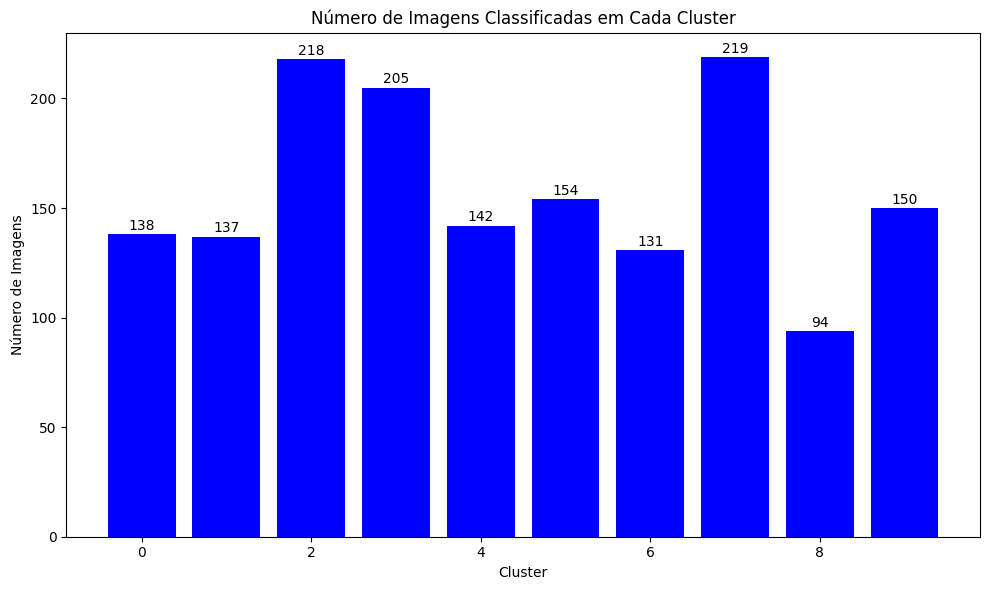

In [14]:
linear_data = pd.DataFrame(linear.values(),index = linear.keys())
nclusters = 10
kmeans = KMeans(n_clusters = nclusters, random_state = 0,n_init = "auto").fit(linear_data.values)
clusters = pd.Series(kmeans.labels_,linear.keys())


cluster_counts = clusters.value_counts().sort_index()


plt.figure(figsize=(10, 6))
plt.bar(cluster_counts.index, cluster_counts.values, color='blue')


plt.xlabel('Cluster')
plt.ylabel('Número de Imagens')
plt.title('Número de Imagens Classificadas em Cada Cluster')


for i, count in enumerate(cluster_counts.values):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom')


plt.tight_layout()
plt.show()

In [15]:
folder = 'ARRAY_FORMAT'
data_files = [os.path.join(folder,name) for name in os.listdir(folder)]
print(f"{len(data_files)} Imagens no total.\n")

data_ex = []

for i in range(len(data_files)):
    img, structures = load(data_files[i]) 
    data_ex.append((img, structures))
    print('Files:',i,end = '\r')

1588 Imagens no total.



### Imagens classificadas pelo modelo

In [17]:
from modelo import Model
model = Model("MODEL")
classes = [model.get_best_class(data_ex[i][0]) for i in range(len(data_ex))]

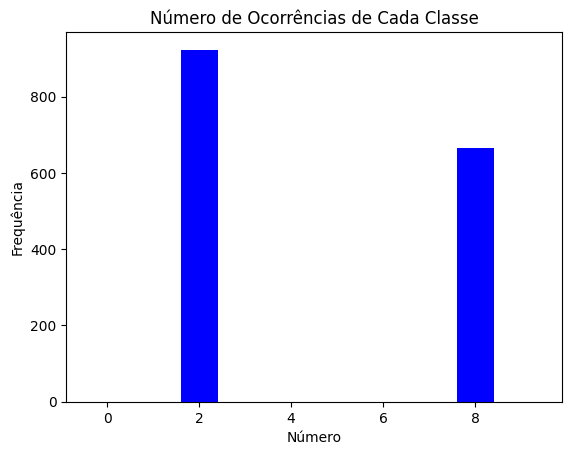

In [18]:

unique, counts = np.unique(classes, return_counts=True)
occurrences = dict(zip(unique, counts))

numbers = np.arange(10)  
frequency = [occurrences.get(num, 0) for num in numbers]

plt.bar(numbers, frequency, color='blue')


plt.xlabel('Número')
plt.ylabel('Frequência')
plt.title('Número de Ocorrências de Cada Classe')

plt.show()

In [25]:
from modelo import load,evaluate,Model,ORGAOS, colors,clean,create_reshape,transform,reduce, remove_black, reverse_transform
import random
img,_ = load(data_files[random.randint(0,len(data_files))])
trasholds = {'artery': 5, 'liver': 1, 'stomach': 11, 'vein': 3}
path = "MODEL"
templates_names = os.listdir(os.path.join(path,'classes'))
classes = [cv2.imread(os.path.join(path,'classes',name),cv2.IMREAD_GRAYSCALE) for name in sorted(templates_names)] 
templates = {org:[cv2.imread(os.path.join(path,'templates',org,name),
                                    cv2.IMREAD_GRAYSCALE) for name in templates_names] for org in ORGAOS}

best_class = None


cleaned = clean(img)
scaler = create_reshape(cleaned)
timg = transform(cleaned,scaler)
simg = reduce(timg)
rimg = remove_black(simg)
best_score = 0
for i,classe in enumerate(classes):
    subtraction = rimg.astype('int32') - classe.astype('int32')
    subtraction[subtraction < 0] = 0
    score = subtraction.sum() / classe.sum()
    if score > best_score:
        best_score = score
        best_class = i
    print(f"classe {i} - resultado classe.sum {classe.sum()}")
print(f"-------------best_class = {best_class}")

classe 0 - resultado classe.sum 434372
classe 1 - resultado classe.sum 425037
classe 2 - resultado classe.sum 201849
classe 3 - resultado classe.sum 261424
classe 4 - resultado classe.sum 495294
classe 5 - resultado classe.sum 254798
classe 6 - resultado classe.sum 218000
classe 7 - resultado classe.sum 256576
classe 8 - resultado classe.sum 201929
classe 9 - resultado classe.sum 286344
-------------best_class = 2


As unicas classes escolhidas por esse método de score são as classes com menor soma, as mais escuras ou com menores estruturas.



Pensei então em usar cosseno de similaridade para classificar e imagens com fundo cinza com as estruturas escuras, exceção do figado. Criei o modelo_cos para isso, funciona igual porém o score de cada classe é calculado diferente. Além disso tentei usar a propia imagem em análise para normalizar o calculo do score.
Portanto: 

    - Model_cos - score = cosseno de similaridade;
    - Model_2 = Usa a propia iamgem em análise para normalizar o score
            subtraction = rimg.astype('int32') - classe.astype('int32')
            subtraction[subtraction < 0] = 0
            score = subtraction.sum() / rimg.sum()

### Model_Cos - imagens de classe:

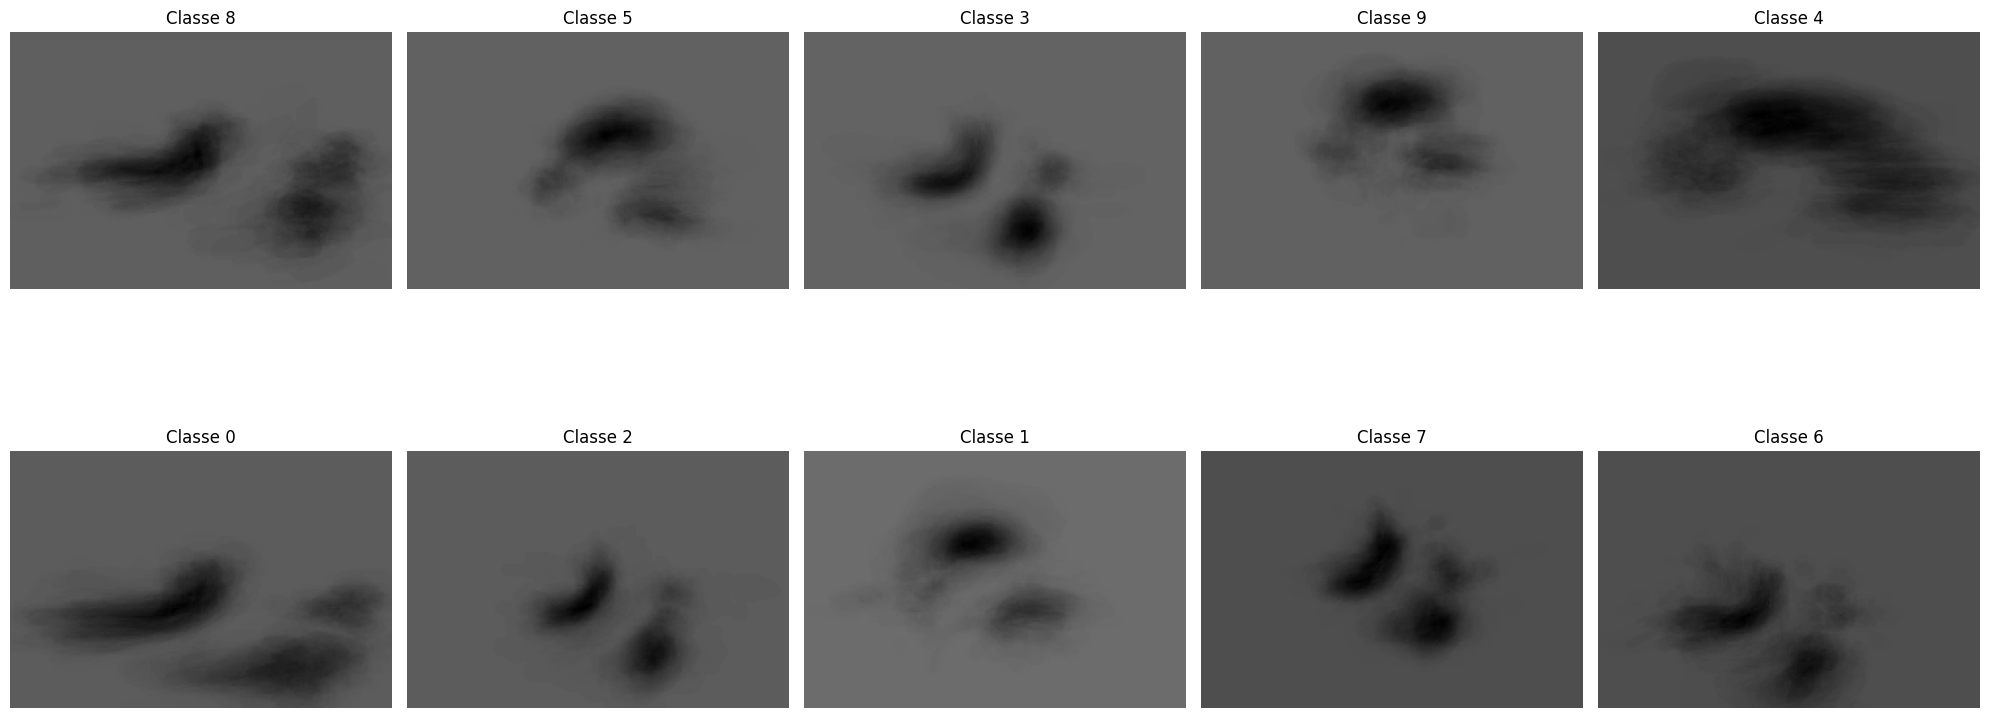

In [30]:
folder_class = 'MODEL_c/classes'
data_files_class = [os.path.join(folder_class,name) for name in os.listdir(folder_class)]


n = len(data_files_class)
num_rows = 2  
num_cols = n//num_rows


fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

for img_idx, img_path in enumerate(data_files_class):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    class_number = img_path.split('/')[-1].split('.')[0]
    row_idx = img_idx // num_cols
    col_idx = img_idx % num_cols
    ax = axes[row_idx, col_idx]
    ax.imshow(img, cmap='gray',vmax=255)
    ax.axis('off')
    ax.set_title(f'Classe {class_number}', fontsize=12)


plt.tight_layout()
plt.show()

In [31]:
from modelo import Model_2,Model_cos
model_2 = Model_2('MODEL')
model_cos = Model_cos("MODEL_c")

classes_2 = []
classes_cos = []

for i in range(len(data_ex)):
    classes_2.append(model_2.get_best_class(data_ex[i][0]))
    classes_cos.append(model_cos.get_best_class(data_ex[i][0]))
    print('Files:',i,end = '\r')

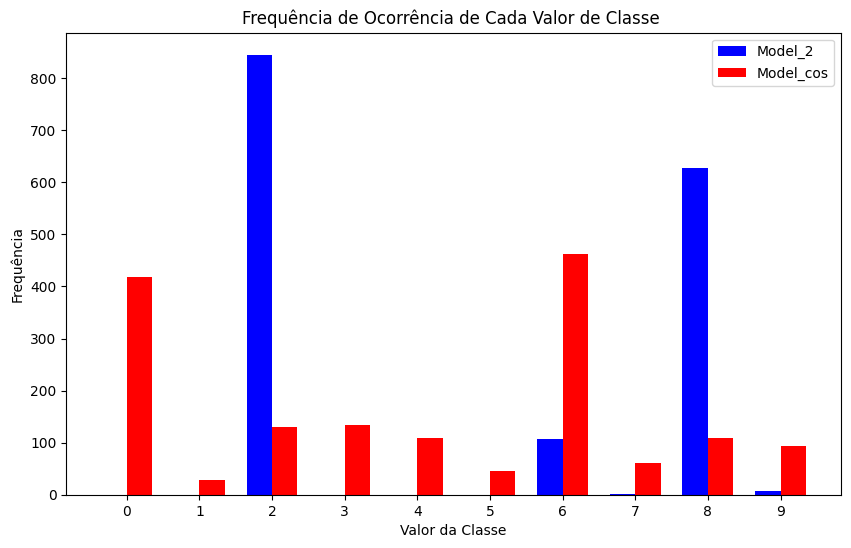

In [33]:
def calculate_frequency(classes):
    unique, counts = np.unique(classes, return_counts=True)
    occurrences = dict(zip(unique, counts))
    numbers = np.arange(10) 
    frequency = [occurrences.get(num, 0) for num in numbers]
    return frequency

frequency_class1 = calculate_frequency(classes_2)
frequency_class2 = calculate_frequency(classes_cos)
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(10)  
bars1 = ax.bar(index, frequency_class1, bar_width, label='Model_2', color='blue')
bars2 = ax.bar(index + bar_width, frequency_class2, bar_width, label='Model_cos', color='red')

ax.set_xlabel('Valor da Classe')
ax.set_ylabel('Frequência')
ax.set_title('Frequência de Ocorrência de Cada Valor de Classe ')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(index)
ax.legend()
plt.show()

No fim mudar a mudança do modelo_2 não alterou muito a distribuição das classes, pq a própria subtração já é enviesada para classes com estruturas menores, mais escuras, como a 2 e a 8.

Já o modelo_cos distribuiu mais as imagens dentro das classes, mas não verifiquei a porcetagem de acerto da classificação.


### Comparações:

Alterei o número de clusters do kmeans e rodei o calculo de precisao e recall

In [49]:

table_precision = pd.read_csv('results/precision_data.csv', index_col=0)
table_recall = pd.read_csv('results/recall_data.csv', index_col=0)


#### 10 clusters:

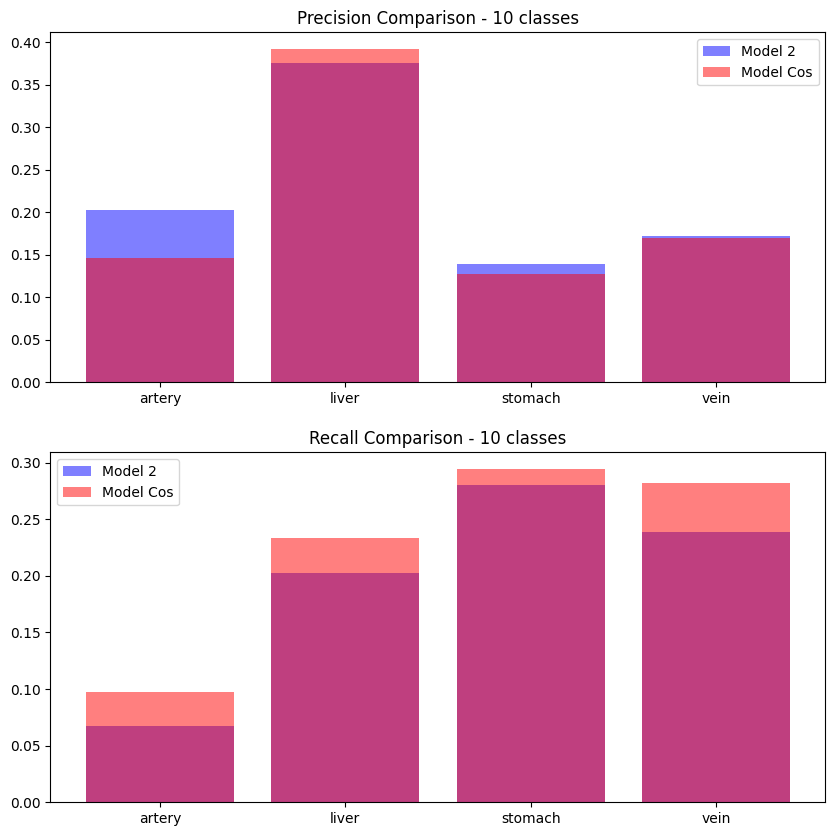

In [46]:

ORGAOS = table_precision.index.tolist()
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
axes[0].bar(ORGAOS, table_precision['Model_2_10classes'], color='blue', alpha=0.5, label='Model 2')
axes[0].bar(ORGAOS, table_precision['Model_Cos_10classes'], color='red', alpha=0.5, label='Model Cos')
axes[0].set_title('Precision Comparison - 10 classes')
axes[0].legend()

axes[1].bar(ORGAOS, table_recall['Model_2_10classes'], color='blue', alpha=0.5, label='Model 2')
axes[1].bar(ORGAOS, table_recall['Model_Cos_10classes'], color='red', alpha=0.5, label='Model Cos')
axes[1].set_title('Recall Comparison - 10 classes')
axes[1].legend()

plt.show()


#### 5 clusters:

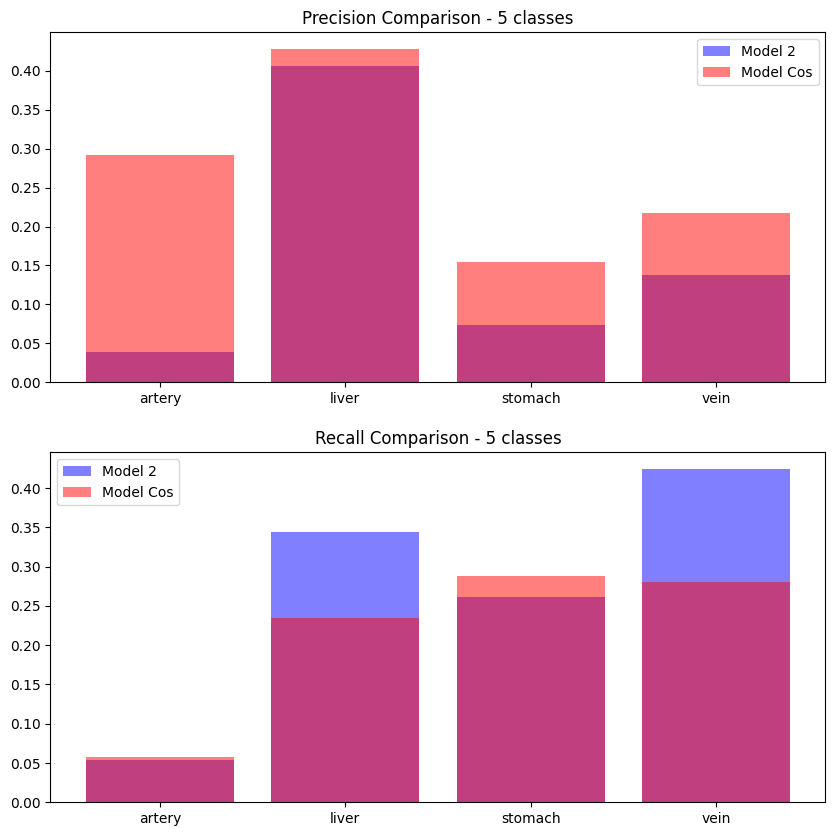

In [45]:

fig, axes = plt.subplots(2, 1, figsize=(10, 10))
axes[0].bar(ORGAOS, table_precision['Model_2_5classes'], color='blue', alpha=0.5, label='Model 2')
axes[0].bar(ORGAOS, table_precision['Model_Cos_5classes'], color='red', alpha=0.5, label='Model Cos')
axes[0].set_title('Precision Comparison - 5 classes')
axes[0].legend()

axes[1].bar(ORGAOS, table_recall['Model_2_5classes'], color='blue', alpha=0.5, label='Model 2')
axes[1].bar(ORGAOS, table_recall['Model_Cos_5classes'], color='red', alpha=0.5, label='Model Cos')
axes[1].set_title('Recall Comparison - 5 classes')
axes[1].legend()

plt.show()

#### 3 clusters:

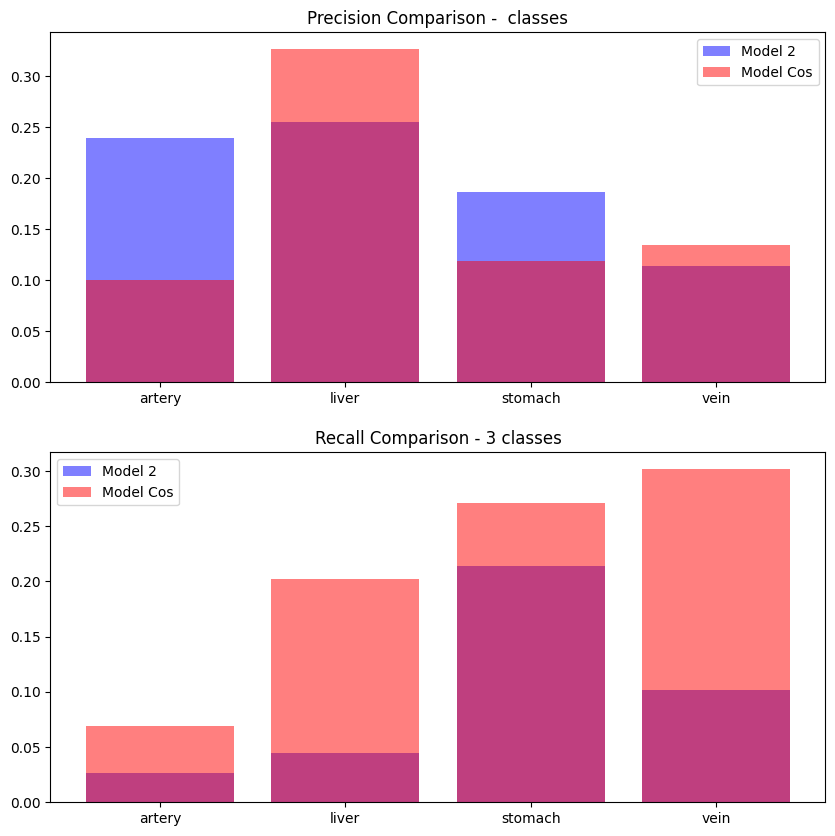

In [47]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
axes[0].bar(ORGAOS, table_precision['Model_2_3classes'], color='blue', alpha=0.5, label='Model 2')
axes[0].bar(ORGAOS, table_precision['Model_Cos_3classes'], color='red', alpha=0.5, label='Model Cos')
axes[0].set_title('Precision Comparison -  classes')
axes[0].legend()

axes[1].bar(ORGAOS, table_recall['Model_2_3classes'], color='blue', alpha=0.5, label='Model 2')
axes[1].bar(ORGAOS, table_recall['Model_Cos_3classes'], color='red', alpha=0.5, label='Model Cos')
axes[1].set_title('Recall Comparison - 3 classes')
axes[1].legend()

plt.show()

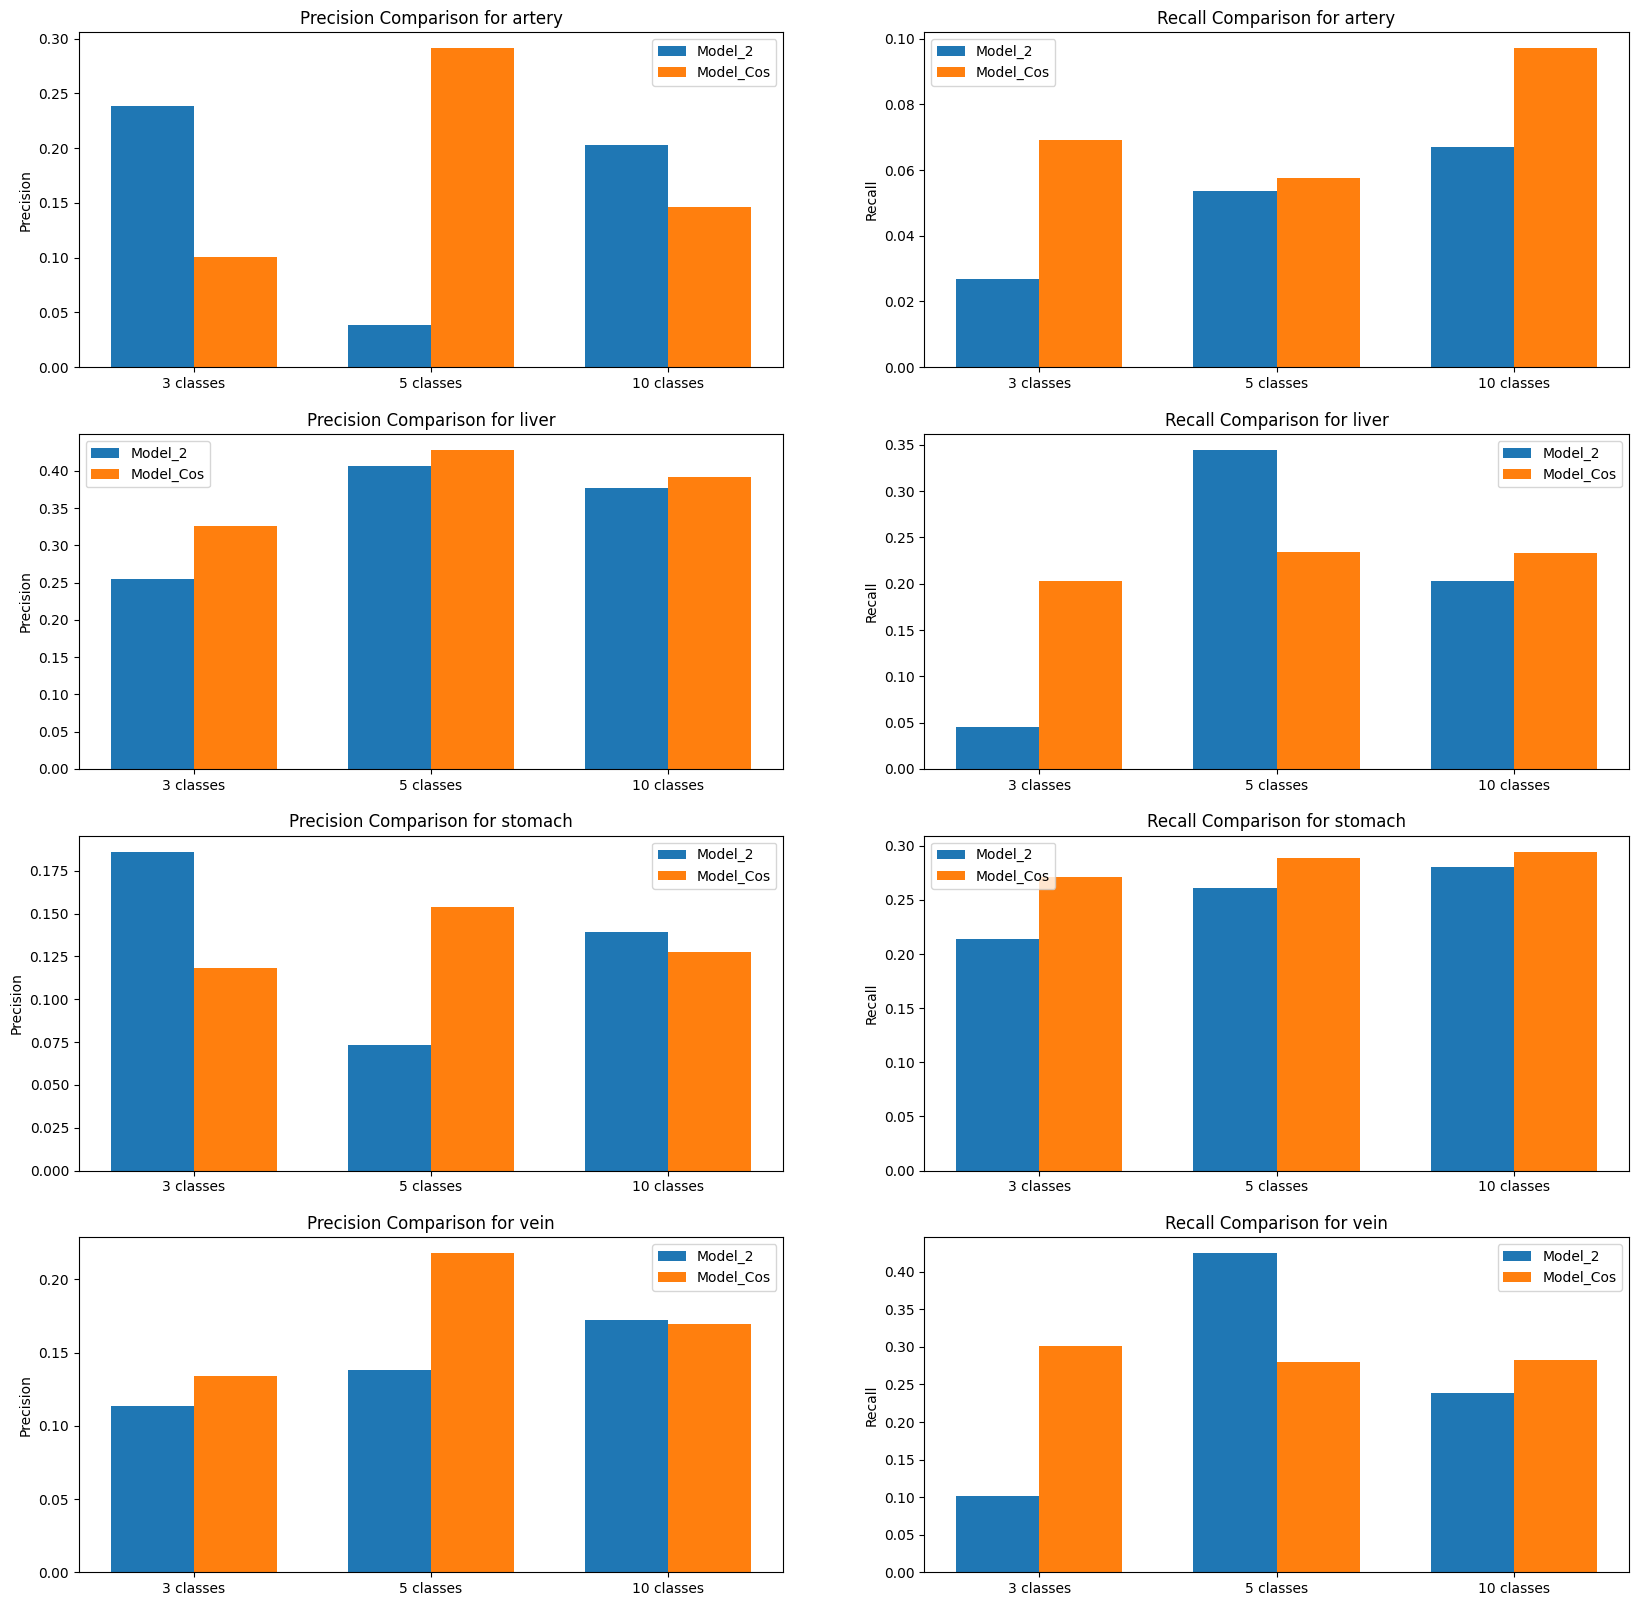

In [61]:
def plot_comparison_for_organ(organ, table_precision, table_recall, ax1, ax2):
    num_classes = ['3 classes', '5 classes', '10 classes']
    models = ['Model_2', 'Model_Cos']

    precision_values = [
        [table_precision[f'{model}_{classes}'][organ] for classes in ['3classes', '5classes', '10classes']]
        for model in models
    ]

    recall_values = [
        [table_recall[f'{model}_{classes}'][organ] for classes in ['3classes', '5classes', '10classes']]
        for model in models
    ]

    x = np.arange(len(num_classes))
    width = 0.35

    ax1.bar(x - width/2, precision_values[0], width, label='Model_2')
    ax1.bar(x + width/2, precision_values[1], width, label='Model_Cos')
    ax1.set_title(f'Precision Comparison for {organ}')
    ax1.set_xticks(x)
    ax1.set_xticklabels(num_classes)
    ax1.set_ylabel('Precision')
    ax1.legend()

    ax2.bar(x - width/2, recall_values[0], width, label='Model_2')
    ax2.bar(x + width/2, recall_values[1], width, label='Model_Cos')
    ax2.set_title(f'Recall Comparison for {organ}')
    ax2.set_xticks(x)
    ax2.set_xticklabels(num_classes)
    ax2.set_ylabel('Recall')
    ax2.legend()

    num_classes = ['3 classes', '5 classes', '10 classes']
    models = ['Model_2', 'Model_Cos']

   

fig, axs = plt.subplots(4, 2, figsize=(20, 20))

for i, organ in enumerate(ORGAOS):
    plot_comparison_for_organ(organ, table_precision, table_recall, axs[i, 0], axs[i, 1])

plt.show()

In [65]:
print("Melhor modelo baseado na precisão:")
print(table_precision.idxmax(axis=1))
print("\nMelhor modelo baseado no recall:")
print(table_recall.idxmax(axis=1))

Melhor modelo baseado na precisão:
artery     Model_Cos_5classes
liver      Model_Cos_5classes
stomach      Model_2_3classes
vein       Model_Cos_5classes
dtype: object

Melhor modelo baseado no recall:
artery     Model_Cos_10classes
liver         Model_2_5classes
stomach    Model_Cos_10classes
vein          Model_2_5classes
dtype: object


No fim a diferença não foi tao grande, num geral o modelo usando coseno de similaridade foi melhor, talvez a gente não precise escolher um unico modelo, mas apresentar as comparações também.